In [3]:
pip install numpy opencv-python scikit-image scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import cv2
import numpy as np
from skimage.filters import threshold_otsu, threshold_sauvola
from sklearn.metrics import jaccard_score

root_dir = "/kaggle/input/datasets/atikaakter11/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset"
image_root = os.path.join(root_dir, "image")
mask_root = os.path.join(root_dir, "mask")

In [5]:
def dice_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-8)

def compute_metrics(gt, pred):
    gt = gt.flatten()
    pred = pred.flatten()
    dice = dice_score(gt, pred)
    jaccard = jaccard_score(gt, pred)
    return dice, jaccard

In [6]:
def otsu_segmentation(image):
    thresh = threshold_otsu(image)
    return (image > thresh).astype(np.uint8)

def sauvola_segmentation(image):
    window_size = 25
    thresh = threshold_sauvola(image, window_size=window_size)
    return (image > thresh).astype(np.uint8)

In [7]:
otsu_dice, otsu_jaccard = [], []
sauvola_dice, sauvola_jaccard = [], []

sample_image = None
sample_mask = None
sample_otsu = None
sample_sauvola = None

for folder in os.listdir(image_root):

    image_folder = os.path.join(image_root, folder)
    mask_folder = os.path.join(mask_root, folder)

    if not os.path.isdir(image_folder):
        continue

    for filename in os.listdir(image_folder):

        img_path = os.path.join(image_folder, filename)

        name = os.path.splitext(filename)[0]
        mask_filename = name + "_m.jpg"
        mask_path = os.path.join(mask_folder, mask_filename)

        image = cv2.imread(img_path, 0)
        mask = cv2.imread(mask_path, 0)


        if image is None or mask is None:
            continue

        if image.shape != mask.shape:
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

        mask = (mask > 127).astype(np.uint8)

        otsu_pred = otsu_segmentation(image)
        sauvola_pred = sauvola_segmentation(image)

        if sample_image is None:
          sample_image = image
          sample_mask = mask
          sample_otsu = otsu_pred
          sample_sauvola = sauvola_pred

        if otsu_pred.shape != mask.shape:
            otsu_pred = cv2.resize(otsu_pred, (mask.shape[1], mask.shape[0]))

        if sauvola_pred.shape != mask.shape:
            sauvola_pred = cv2.resize(sauvola_pred, (mask.shape[1], mask.shape[0]))

        d_o, j_o = compute_metrics(mask, otsu_pred)
        d_s, j_s = compute_metrics(mask, sauvola_pred)

        otsu_dice.append(d_o)
        otsu_jaccard.append(j_o)
        sauvola_dice.append(d_s)
        sauvola_jaccard.append(j_s)

print("OTSU")
print("Average Dice:", np.mean(otsu_dice))
print("Average Jaccard:", np.mean(otsu_jaccard))

print("\nSAUVOLA")
print("Average Dice:", np.mean(sauvola_dice))
print("Average Jaccard:", np.mean(sauvola_jaccard))

OTSU
Average Dice: 0.04516251955821458
Average Jaccard: 0.02432912811520497

SAUVOLA
Average Dice: 0.02876679286759531
Average Jaccard: 0.015007767311658685


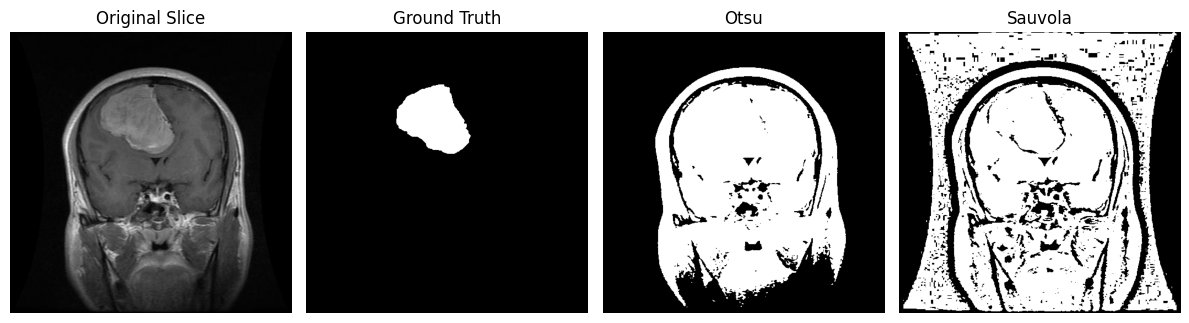

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(sample_image, cmap='gray')
plt.title("Original Slice")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(sample_mask, cmap='gray')
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(sample_otsu, cmap='gray')
plt.title("Otsu")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(sample_sauvola, cmap='gray')
plt.title("Sauvola")
plt.axis("off")

plt.tight_layout()
plt.show()
